<a href="https://colab.research.google.com/github/ghassanbaltaji/Analyzing_Financial_Articles/blob/main/Analyzing_FinancialArticles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

import io
import pandas as pd
import re
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
#models
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
#metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

from collections import Counter, defaultdict

from numpy import random
SEED = 42
random.seed(SEED)

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.cm as cm 

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

!pip install langdetect
from langdetect import detect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Upload original dataset: dataset.csv
uploaded = files.upload()

Saving dataset.csv to dataset (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))
df

,ts,body,stock,positive,negative
0,2011-01-17,"* Co-founded Apple in 1976 * IPod, iPhone, ...",AAPL,11,19
1,2011-01-24,"PARK CITY, Utah (Reuters) - Film director Kevi...",TWTR,5,9
2,2013-01-14,* Tender terms seen this month * Istanbul grow...,BAC,1,2
3,2011-08-22,"NEW YORK, Aug 20 (IFR) - US equity capital ma...",BAC,8,13
4,2011-01-27,"LONDON, Jan 27 (Reuters) - Britain's FTSE 100...",AMZN,5,10
...,...,...,...,...,...
1995,2011-08-24,* Posts loss of 17 cnts/shr vs Street View ...,T,9,9
1996,2013-06-04,"CHICAGO, June 4 (Reuters) - United Airlines’ c...",DAL,1,4
1997,2013-05-12,TAIPEI (Reuters) - Hon Hai Precision Industry ...,AAPL,11,5
1998,2015-06-02,ROME (Thomson Reuters Foundation) - In a caver...,DAL,8,33


In [ ]:
len(df)

2000

In [ ]:
#remove articles in language different than english language
df_eng = df.copy()
df_not_eng = df.copy()

for i_row in range(0,len(df)-1):
  if (detect(df.iloc[i_row]['body']) != 'en'):
    df_eng = df_eng.drop(i_row)
  else: df_not_eng = df_not_eng.drop(i_row)
df_eng


,ts,body,stock,positive,negative
0,2011-01-17,"* Co-founded Apple in 1976 * IPod, iPhone, ...",AAPL,11,19
1,2011-01-24,"PARK CITY, Utah (Reuters) - Film director Kevi...",TWTR,5,9
2,2013-01-14,* Tender terms seen this month * Istanbul grow...,BAC,1,2
3,2011-08-22,"NEW YORK, Aug 20 (IFR) - US equity capital ma...",BAC,8,13
4,2011-01-27,"LONDON, Jan 27 (Reuters) - Britain's FTSE 100...",AMZN,5,10
...,...,...,...,...,...
1995,2011-08-24,* Posts loss of 17 cnts/shr vs Street View ...,T,9,9
1996,2013-06-04,"CHICAGO, June 4 (Reuters) - United Airlines’ c...",DAL,1,4
1997,2013-05-12,TAIPEI (Reuters) - Hon Hai Precision Industry ...,AAPL,11,5
1998,2015-06-02,ROME (Thomson Reuters Foundation) - In a caver...,DAL,8,33


In [ ]:
df_not_eng

,ts,body,stock,positive,negative
30,2011-03-21,Gemalto et STMicroelectronics s’associent pou...,TWTR,1,2
79,2011-07-27,"MILANO, 27 luglio (Reuters) - Nuon Energy, so...",DAL,0,2
199,2011-12-08,"FRANCOFORTE, 8 dicembre (Reuters) - Le banche ...",TWTR,0,0
276,2011-09-27,"L’AQUILA, 27 settembre(Reuters) - L’Italia de...",DAL,0,0
376,2011-10-19,"LISBOA, 19 Out (Reuters) - O PSI20 encerrou em...",AAPL,0,2
550,2011-02-15,JPMorgan Chase annuncia nuovi programmi per i...,DAL,0,0
600,2011-04-20,Nordson EFD ha sido galardonada con el Premio...,TWTR,0,1
751,2013-06-27,*** TO SEE THE DATES BEFORE Aug 7 - PLEASE CLI...,DAL,1,1
1118,2011-03-02,LA FUNDACIÓN FAMILIA HERBALIFE INAUGUR...,TWTR,0,2
1152,2013-06-13,*** TO SEE THE DATES BEFORE Aug 7 - PLEASE CLI...,DAL,1,1


In [ ]:
TECH = ['TECH','AAPL', 'GOOGL', 'AMZN', 'TWTR']
TLC = ['TLC','T', 'VZ']
BANK = ['BANK','GS', 'BAC']
AIR = ['AIR','DAL', 'LUV']

labels = [TLC,TECH,BANK,AIR]

y = []
for i_row in range(0, len(df_eng)):
  x = df_eng.iloc[i_row]['stock']
  for lab in labels:
    if(x in lab):
      y_lab = lab[0]
      y.append(y_lab)

label_category = y
df_eng['category'] = label_category

In [ ]:
df_eng['category'].value_counts()

TECH    792
BANK    400
TLC     400
AIR     388
Name: category, dtype: int64

In [ ]:
df_eng.describe()

,positive,negative
count,1980.000000,1980.000000
mean,4.256566,10.470707
std,12.010389,28.812450
min,0.000000,0.000000
25%,1.000000,2.000000
50%,3.000000,7.000000
75%,6.000000,14.000000
max,501.000000,1212.000000


In [ ]:
df_eng['stock'].value_counts()

T        200
BAC      200
VZ       200
AMZN     200
GS       200
GOOGL    199
LUV      199
AAPL     198
TWTR     195
DAL      189
Name: stock, dtype: int64

In [ ]:
df_eng['ts'] = pd.to_datetime(df_eng['ts']) 
df_eng['year'] = df_eng['ts'].apply(lambda x: x.year)

df_eng = df_eng.sort_values(by = 'ts')
df_eng['ts'].apply(lambda x: x.year).unique()

array([2011, 2013, 2015])

In [ ]:
index = []
for i_row in range(0, len(df_eng)):
  pos = df_eng.iloc[i_row]['positive']
  neg = df_eng.iloc[i_row]['negative']
  if(pos == 0):
    index.append(0)
  else: index.append((pos)/(pos+neg)*100)

df_eng['index'] = index

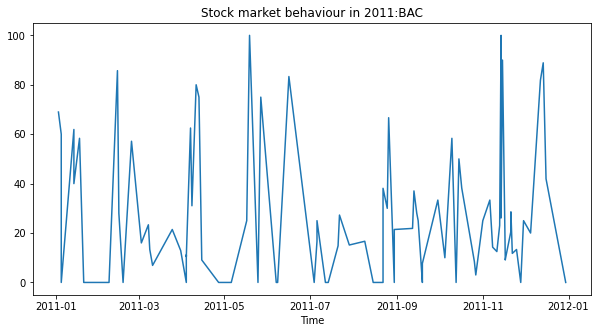

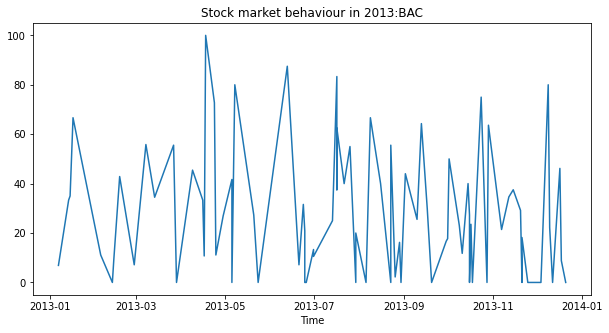

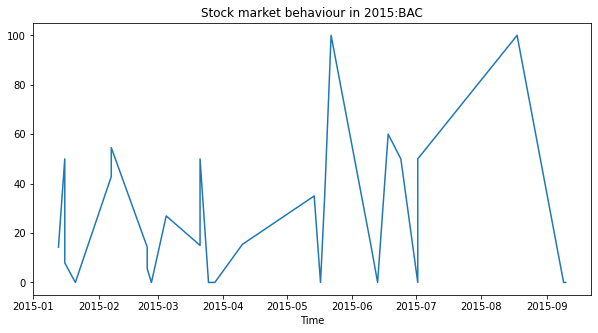

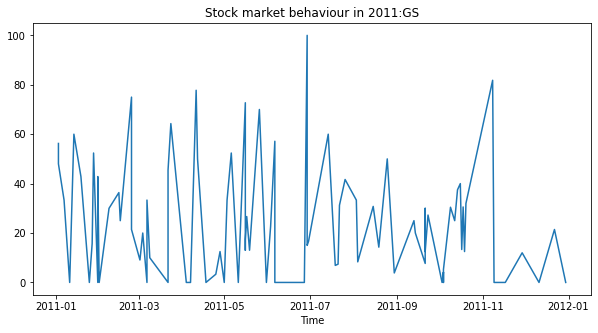

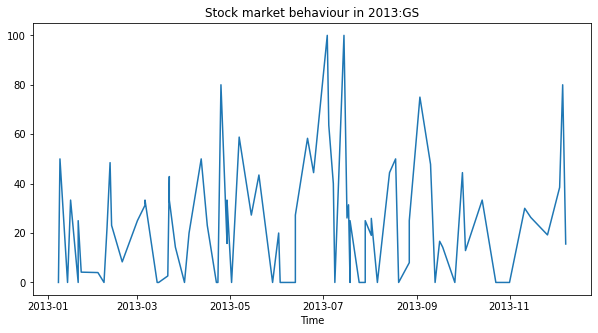

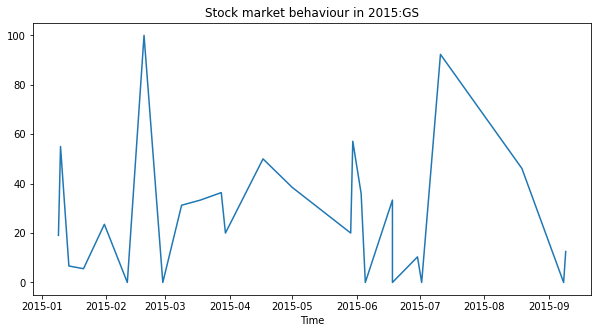

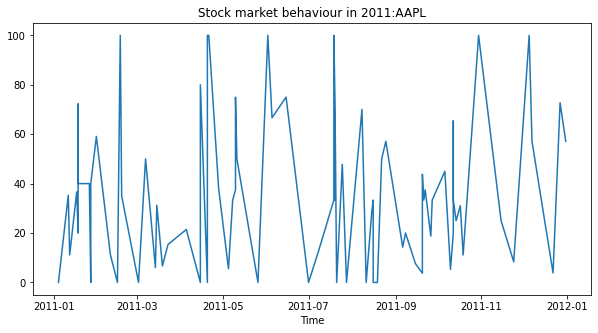

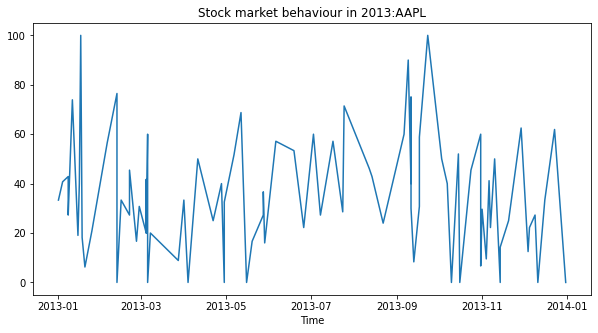

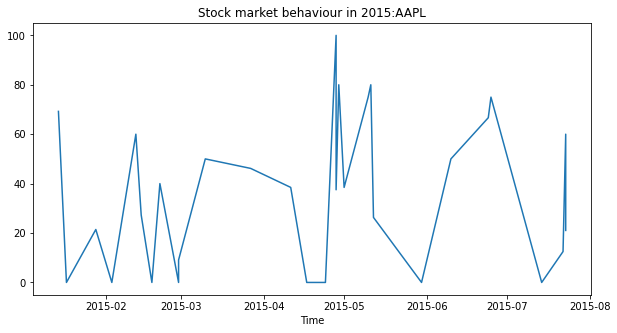

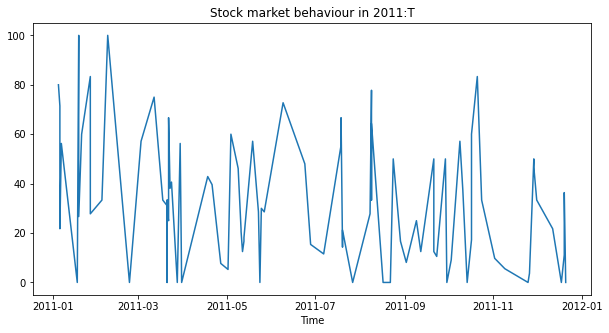

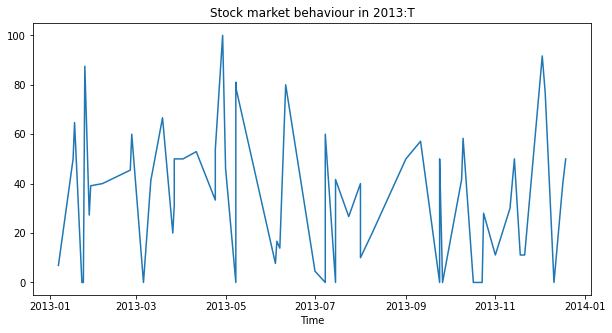

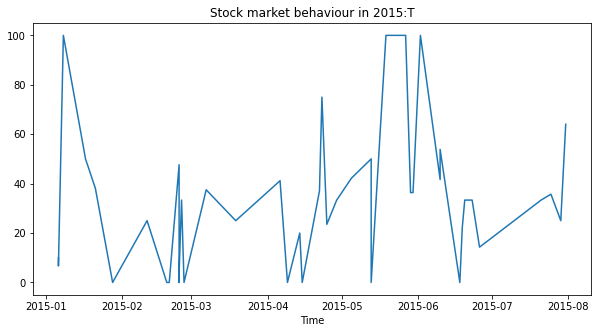

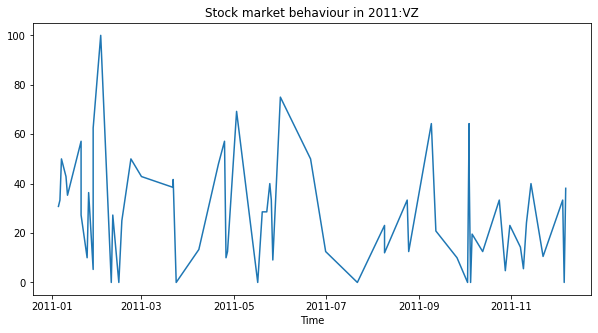

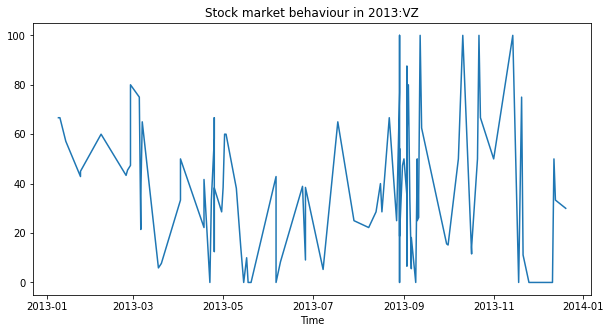

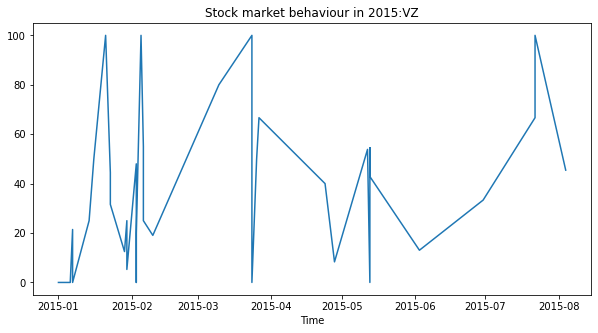

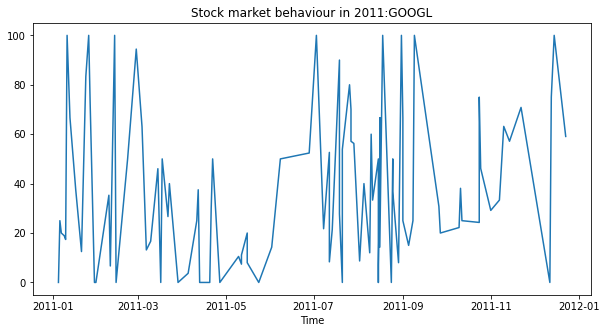

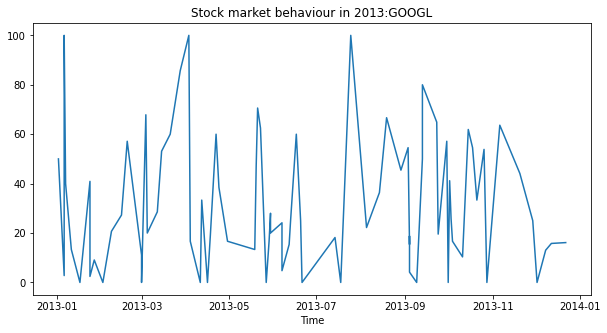

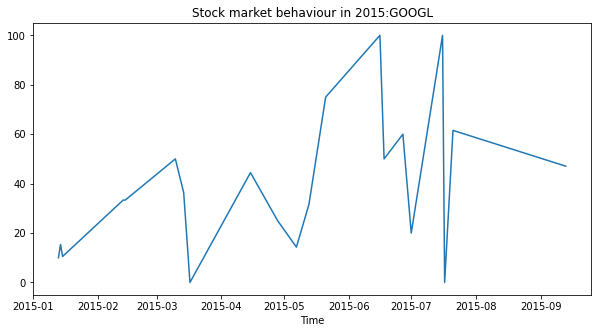

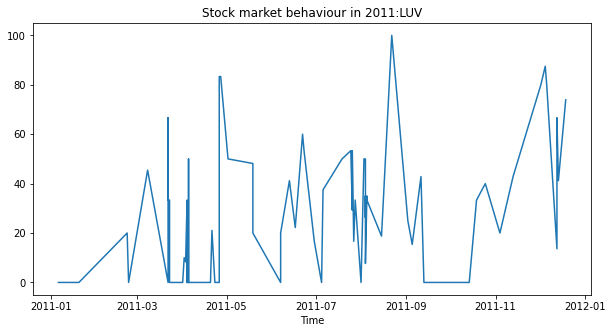

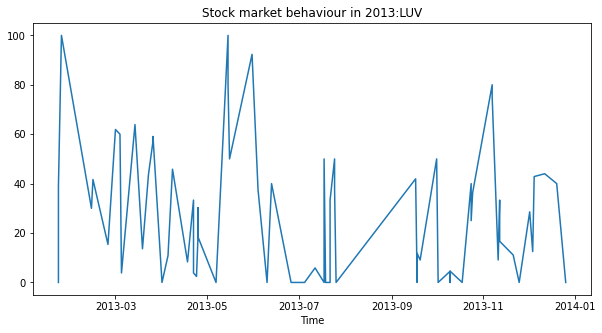

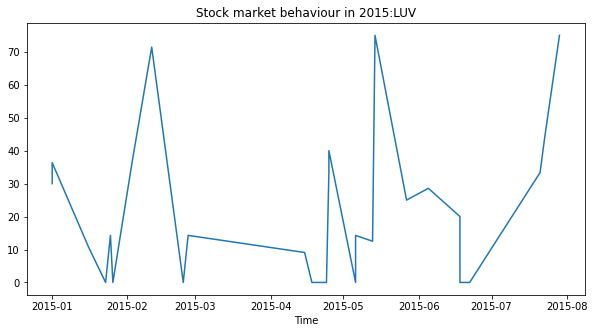

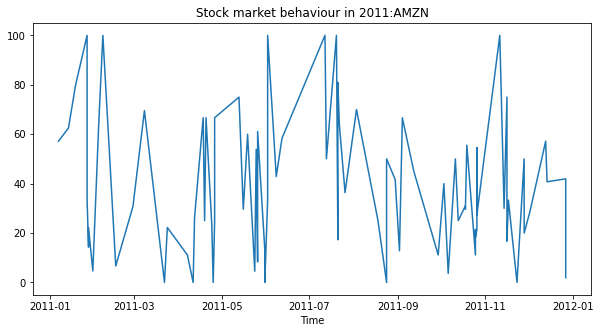

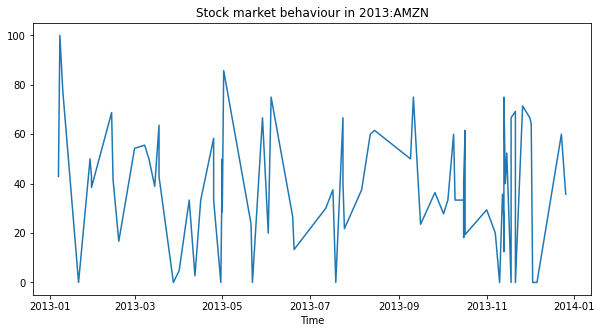

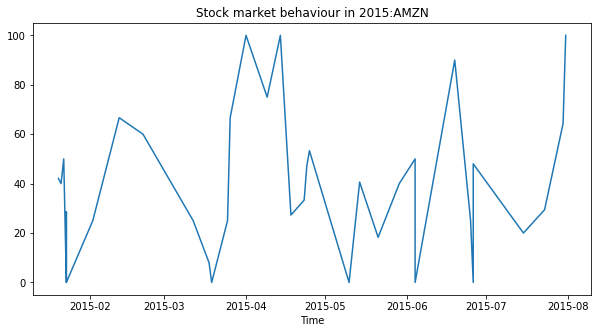

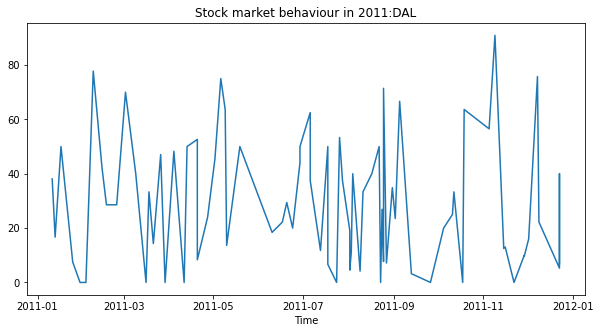

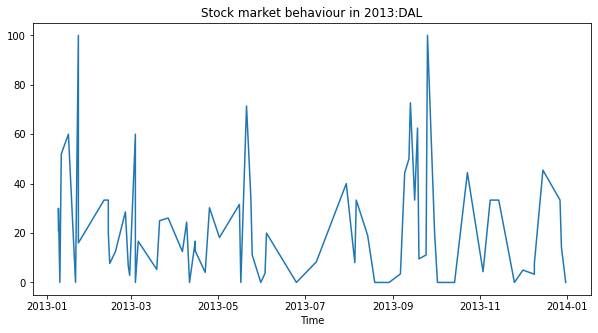

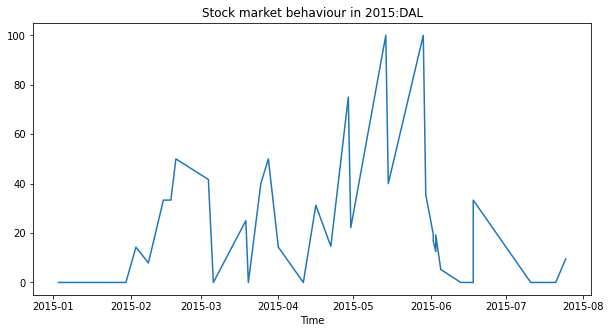

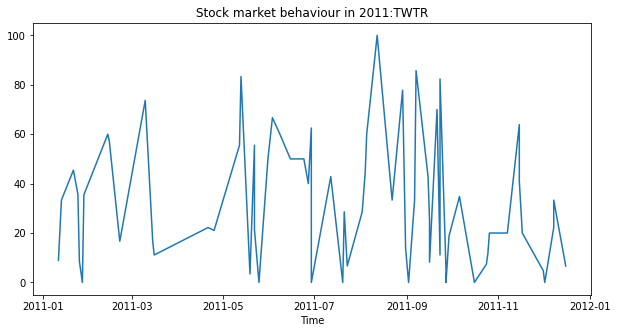

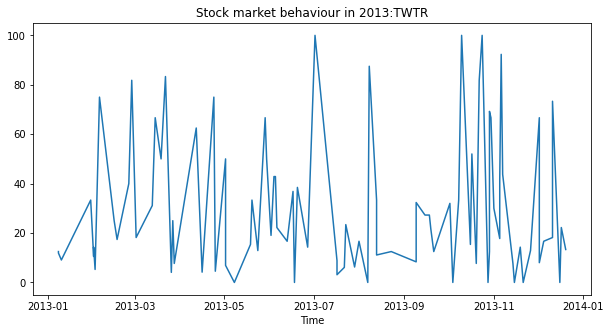

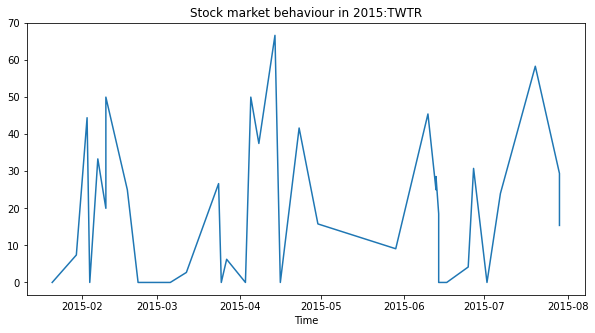

In [ ]:
# Trend over time of the index value for each stock, for each year
for act in df_eng['stock'].unique():
  for year in [2011,2013,2015]:
    df_year = df_eng[df_eng['ts'].apply(lambda x: x.year) == year]
    plt.figure(figsize = (10,5))
    plt.plot(df_year[df_year['stock'] == act]['ts'], df_year[df_year['stock'] == act]['index'])
    plt.title('Stock market behaviour in ' + str(year)+':' + act)
    plt.xlabel('Time')
    plt.show()

In [ ]:
#Preprocessing

wip = df_eng

In [ ]:
#Text cleanup

stop_words = set(stopwords.words('english')) 
def stop(string):
  stopped = []
  for w in string:
    if w not in stop_words:
      stopped.append(w)
  return stopped

In [ ]:
porter = PorterStemmer() #stem
text_low = wip['body'].apply(lambda x: x.lower())
text_tokenize = text_low.apply(lambda x: re.findall('[a-z]{3,20}', x))
text_stemmed = text_tokenize.apply(lambda x: [porter.stem(ele) for ele in x])
text_stopped = text_stemmed.apply(lambda x: stop(x))
text_len = text_stopped.apply(lambda x: len(x))
low = np.quantile(text_len, 0.05)
up = np.quantile(text_len, 0.95)
text_sample = text_stopped[(text_stopped.apply(lambda x: len(x) >= low and len(x) <= up))]
text_proc = text_sample.apply(lambda x: ' '.join(x))

In [ ]:
df_eng = df_eng.loc[list(text_sample.index.values)]
len(df_eng)
#df_eng.to_csv('d40_eng.csv')
#files.download('d40_eng.csv')


1782

In [ ]:
# Generate term-document matrix
# TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.05, max_df = 0.4, token_pattern = '[a-z]{3,20}', stop_words = {'english'})
vect_idf = vectorizer.fit_transform(text_proc)
df_idf = pd.DataFrame(vectorizer.idf_, index = vectorizer.get_feature_names(), columns = ['idf_weights'])

# sort ascending
df_idf.sort_values(by = ['idf_weights'])



,idf_weights
two,1.934972
week,1.939267
unit,1.946467
york,1.947913
price,1.962490
...,...
fli,3.964264
factor,3.964264
item,3.975193
respect,3.975193


In [ ]:
tf_idf_matrix = pd.DataFrame(
    vectorizer.fit_transform(text_proc).toarray(), 
    columns = vectorizer.get_feature_names(),
    index = text_proc.index
)
#tf_idf_matrix.to_csv('tf_idf_matrix.csv')
#files.download('tf_idf_matrix.csv')
tf_idf_matrix

,aapl,abil,abl,abov,access,accord,account,accus,acquir,acquisit,across,act,action,activ,add,addit,address,administr,advanc,advertis,advis,affect,agenc,aggress,ago,agre,agreement,ahead,aim,air,aircraft,airlin,airport,airway,allow,almost,along,alreadi,although,alway,...,vodafon,volatil,volum,vote,wait,wall,want,warn,washington,watch,way,weak,web,websit,wednesday,week,weigh,well,went,whether,whi,white,whose,wide,win,wireless,within,without,work,worker,world,worldwid,worri,worth,write,wrote,yet,yield,york,zone
721,0.054219,0.000000,0.000000,0.0,0.000000,0.027834,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.033362,0.0,0.000000,0.139926,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.044535,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.049923,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.070267,0.046888,0.0,0.0,0.000000,0.000000,0.0,0.031321,0.00000,0.000000,0.053537,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.031348,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.054427,0.000000
169,0.000000,0.000000,0.000000,0.0,0.044519,0.051912,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.037864,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.035947,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.033945,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.087622,0.00000,0.037864,0.049925,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.043122,0.0,0.0,0.041530,0.0,0.076133,0.000000
966,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.040348,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.025143,0.0,0.264459,0.000000,0.0,0.038682,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.089949,0.027433,0.000000,0.09314,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.040837,0.0,0.047209,0.00000,0.030600,0.000000,0.289038,0.035399,0.0,0.036453,0.0,0.104018,0.000000,0.121838,0.0,0.023625,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.020509,0.000000
727,0.111881,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.11336,0.000000,0.0,0.0,0.000000,0.075114,0.000000,0.00000,0.00000,0.072498,0.000000,0.0,0.0,0.000000,0.055907,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.085236,0.000000,0.0,0.064687,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.112312,0.000000
1307,0.000000,0.000000,0.178116,0.0,0.000000,0.000000,0.416425,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.069592,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,0.000000,0.000000,0.000000,0.0,0.000000,0.053144,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.050734,0.000000,0.000000,0.0,0.0,0.046532,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.095319,0.0,0.0,0.000000,0.000000,0.000000,0.000

In [ ]:
#Clustering
#Determine the number of cluster

N = len(tf_idf_matrix)

def SS_compute(cc):
  ss = 0
  for key in cc.keys():
    ss += (cc.get(key)/N)**2
  return ss

def find_optimal_clusters(data, max_k):
    iters = range(3, max_k+1, 1)    
    ss = []
    sse = []
    inv_k = []
    for k in iters:
        estimator = KMeans(n_clusters = k, n_init = 10, random_state = SEED).fit(data)
        count = Counter(estimator.labels_)
        ss_computed = SS_compute(count)
        ss.append(ss_computed*k)
        inv_k.append(1)
        sse.append(estimator.inertia_)
    f, (ax_ss, ax_sse) = plt.subplots(1, 2, figsize = (15, 5))
    ax_ss.plot(iters, ss)
    ax_ss.plot(iters, inv_k)
    ax_ss.set_xlabel('Numero di cluster')
    ax_ss.set_xticks(iters)
    ax_ss.set_xticklabels(iters)
    ax_ss.set_ylabel('% SS sul valore ottimale')
    ax_ss.set_title('% SS sul valore ottimale al variare di k')
    ax_sse.plot(iters, sse)
    ax_sse.set_xlabel('Numero di cluster')
    ax_sse.set_xticks(iters)
    ax_sse.set_xticklabels(iters)
    ax_sse.set_ylabel('SSE')
    ax_sse.set_title('SSE al variare di k')
    opt = ss.index(min(ss[2:12]))+3
    print("Il valore ottimale di k in base al valore SS è:", opt)
    return opt

Il valore ottimale di k in base al valore SS è: 5


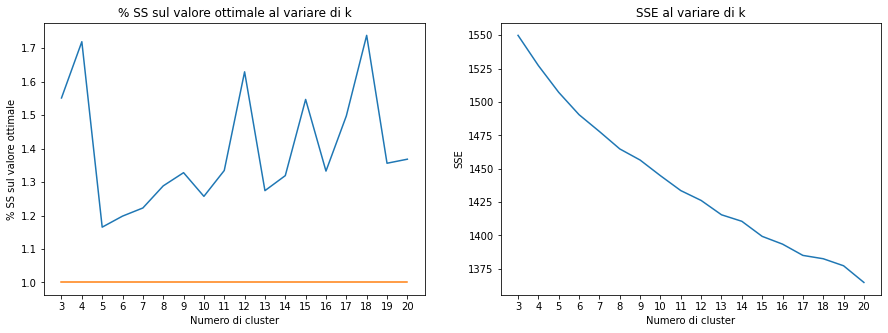

In [ ]:
opt_k = find_optimal_clusters(tf_idf_matrix, 20)

In [ ]:
#Generate clusters

k = opt_k
clusters = KMeans(n_clusters = k, n_init = 10, random_state = SEED).fit(tf_idf_matrix)
count = Counter(clusters.labels_)

label_cluster = list(clusters.labels_)
df_eng['cluster'] = label_cluster

print(count)

Counter({0: 562, 4: 462, 2: 366, 1: 197, 3: 195})


In [ ]:
# Cluster per stock
df_eng.groupby('cluster')['stock'].value_counts().unstack().fillna(0).astype(int)

stock,AAPL,AMZN,BAC,DAL,GOOGL,GS,LUV,T,TWTR,VZ
cluster,,,,,,,,,,
0,32,62,20,72,93,28,28,43,141,43
1,39,18,25,8,13,30,8,26,2,28
2,15,10,123,23,15,109,2,25,13,31
3,0,1,1,55,0,3,128,1,5,1
4,95,95,2,4,61,11,2,84,19,89


In [ ]:
# Cluster per category
df_eng.groupby('category')['cluster'].value_counts().unstack().fillna(0).astype(int)

cluster,0,1,2,3,4
category,,,,,
AIR,100,16,25,183,6
BANK,48,55,232,4,13
TECH,328,72,53,6,270
TLC,86,54,56,2,173


In [ ]:
# Cluster per year
df_eng.groupby('cluster')['year'].value_counts().unstack().fillna(0).astype(int)

year,2011,2013,2015
cluster,,,
0,231,232,99
1,81,85,31
2,157,153,56
3,89,78,28
4,228,169,65


In [ ]:
clusters_pred = KMeans(n_clusters = k, random_state = SEED).fit_predict(tf_idf_matrix)

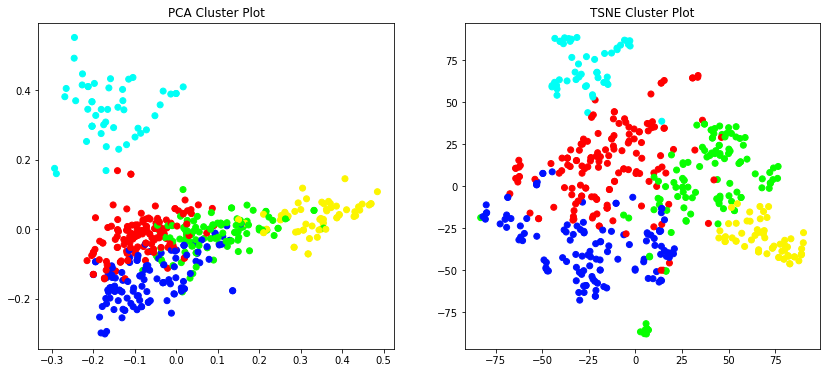

In [ ]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)+2
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=12).fit_transform(data[max_items,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

text = vectorizer.transform(text_proc)
plot_tsne_pca(text, clusters_pred)

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()
    for i,r in df.iterrows():
      print('\nCluster {}'.format(i))
      print(', '.join([labels[t] for t in np.argsort(r)[:-n_terms:-1]]))
      
get_top_keywords(tf_idf_matrix, clusters_pred, vectorizer.get_feature_names(), 10)




Cluster 0
state, govern, twitter, corp, court, peopl, say, rule, nation

Cluster 1
index, stock, dow, nasdaq, point, rose, gain, fell, pct

Cluster 2
bank, bond, debt, fund, rate, invest, deal, citi, goldman

Cluster 3
airlin, flight, southwest, plane, boe, airport, delta, air, carrier

Cluster 4
appl, mobil, verizon, wireless, googl, servic, iphon, sale, network


In [ ]:
df_eng.loc[df_eng['cluster'] == 1, 'body'].head(10)

721      * Factory, construction data show growing eco...
872       * Some top U.S. retailers miss views for Dec...
356     NEW YORK (Reuters) - Stocks fell on Friday aft...
1268    NEW YORK (Reuters) - Energy shares helped the ...
1689    NEW YORK (Reuters) - Energy shares helped the ...
1756     * Property leads gains on Nomura Securities t...
1257     NEW YORK, Jan 18 (Reuters) - The Nasdaq 100 i...
1493    NEW YORK (Reuters) - U.S. stocks erased losses...
4        LONDON, Jan 27 (Reuters) - Britain's FTSE 100...
822       * Market stays near 29-month highs, supporte...
Name: body, dtype: object

Text(0, 0.5, 'Variance explained')

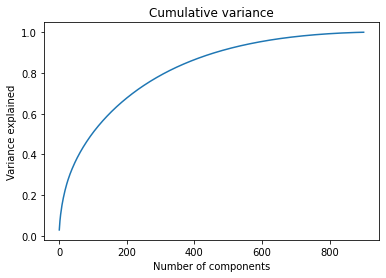

In [ ]:
#Classification
X = tf_idf_matrix
X_pca = PCA(random_state = SEED).fit(X)

cumvar = np.cumsum(X_pca.explained_variance_ratio_)

#Plotting cumulative variance
plt.plot(cumvar)
plt.title('Cumulative variance')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')


In [ ]:
cumvar[500]

0.9185062729238044

In [ ]:
n_used = 500
X_pca = np.dot(X.values, X_pca.components_[:n_used,:].T)
X_pca = pd.DataFrame(X_pca, columns=["PC%d" % (x + 1) for x in range(n_used)])
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,...,PC461,PC462,PC463,PC464,PC465,PC466,PC467,PC468,PC469,PC470,PC471,PC472,PC473,PC474,PC475,PC476,PC477,PC478,PC479,PC480,PC481,PC482,PC483,PC484,PC485,PC486,PC487,PC488,PC489,PC490,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500
0,0.519364,0.080496,0.195287,-0.070230,-0.197864,-0.041316,-0.078350,0.036987,-0.082309,0.188486,0.006907,-0.054345,-0.133913,-0.006164,-0.021924,-0.045779,0.113624,0.148871,0.026367,-0.016204,-0.010511,0.021234,-0.088264,-0.068294,-0.034316,-0.030026,-0.019079,-0.064970,-0.046538,-0.069131,0.081967,-0.025916,0.051303,0.016253,0.034969,-0.028973,-0.029970,0.024658,-0.010659,-0.016137,...,-0.018780,0.014099,-0.023459,0.003377,-0.009029,-0.024498,0.008523,0.017665,-0.014154,-0.034001,0.062041,0.026680,0.023795,0.018503,0.011761,-0.025790,-0.000746,0.023477,0.025315,-0.009352,-0.011006,-0.036454,-0.020029,0.024844,0.011857,-0.015989,-0.019252,0.007059,-0.020065,0.044925,-0.031528,0.040664,-0.017902,0.019288,-0.009029,0.016950,-0.014135,0.003590,0.020560,-0.021175
1,0.088404,-0.092133,-0.111716,0.008218,0.059553,-0.171335,0.073374,-0.073760,-0.033812,0.192667,0.013043,0.004607,-0.128207,0.024030,-0.136273,-0.016145,0.064016,0.032305,-0.094420,0.019245,-0.003005,0.002056,-0.001688,-0.196215,-0.110985,0.008650,0.064892,-0.048080,-0.136897,-0.076954,-0.059812,-0.036343,-0.153830,-0.013740,-0.002657,-0.123596,0.076818,-0.078078,-0.112333,0.146370,...,-0.027033,-0.008721,-0.017633,0.041777,0.026160,-0.021987,0.004727,-0.001246,0.006622,0.028166,-0.002480,-0.014773,-0.036469,-0.000399,0.013200,0.000190,-0.017418,-0.002503,-0.003743,0.018420,-0.019190,0.001237,-0.000379,-0.039580,-0.002004,-0.008783,-0.016790,0.006833,0.002708,0.024569,0.017838,0.011825,0.008157,-0.005577,0.015134,0.002879,0.023958,-0.017570,-0.000239,-0.037710
2,0.041045,-0.000104,-0.103240,-0.061297,-0.084527,-0.180266,-0.018943,0.042234,0.004363,-0.046924,-0.001998,0.000610,-0.203223,0.055550,0.013673,0.084665,-0.013344,0.077860,0.271911,0.028614,0.045357,0.055803,-0.195694,-0.011612,-0.077468,-0.003213,0.004628,0.058443,0.021719,0.052605,-0.095256,-0.049854,-0.152261,-0.151249,-0.059327,0.015941,0.052292,-0.051082,-0.084879,0.023147,...,-0.015474,0.004442,-0.018235,-0.030390,0.004461,-0.019716,-0.010503,-0.016600,-0.018125,0.031045,0.000880,0.032826,0.000420,0.014563,0.034297,0.031270,-0.010153,-0.002732,-0.003602,0.002489,0.041619,-0.020659,0.003325,0.020310,0.001995,-0.012817,0.003478,0.045937,-0.000222,0.018176,0.025854,0.007726,0.000909,0.001975,-0.029290,-0.008506,-0.000466,0.004276,0.005996,-0.009529
3,0.130270,-0.077465,0.146951,0.020535,-0.017866,-0.059055,-0.044621,0.068465,-0.035499,0.010063,-0.016339,-0.062662,-0.006581,0.029892,-0.062397,-0.000428,0.001975,0.131557,0.028710,0.027678,-0.018021,0.013574,0.001789,-0.015691,-0.129932,-0.022480,0.052396,-0.053528,-0.019457,-0.040870,-0.015644,-0.057597,-0.070804,-0.005938,-0.019829,-0.081495,-0.133250,0.048476,-0.059568,-0.013886,...,0.010769,-0.013045,0.007000,0.058071,0.024018,0.023039,0.012989,-0.016473,-0.040615,0.062288,0.034084,0.012256,-0.055001,0.005423,-0.061083,-0.009067,0.076569,-0.005314,0.013737,0.004511,0.044097,0.029926,-0.043733,0.006298,-0.022663,-0.042898,-0.030647,-0.030509,0.020403,-0.023750,-0.033333,-0.041468,-0.002655,0.031678,0.006136,0.019697,0.010915,0.085920,-0.042269,0.010642
4,0.067852,-0.013605,-0.151775,0.091807,0.110969,-0.153594,0.151912,0.124280,0.023040,0.046999,0.255156,-0.086574,-0.085324,-0.008165,0.055141,-0.067271,-0.003046,0.074476,0.073337,0.054201,0.063293,-0.017978,0.022910,-0.050450,-0.040406,0.018110,-0.042659,-0.099747,0.021835,-0.090662,0.013529,-0.021407,-0.083936,0.073746,-0.054152,0.064064,-0.046644,0.137904,-0.056957,-0.160257,...,-0.010352,0.006449,-0.021987,-0.001315,-0.038287,-0.044565,-0.043265,0.004397,-0.015597,0.005028,0.006

In [ ]:
#On clusters

y = df_eng['cluster']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = SEED, stratify = y)

In [ ]:
levels = pd.unique(y)

In [ ]:
classification_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])


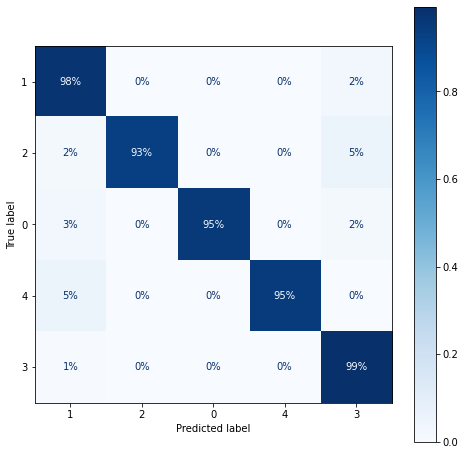

In [ ]:
# LOGISTIC REGRESSION
logistic = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs').fit(X_train, y_train)
logistic_predict = logistic.predict(X_test)

#metrics:
logi_acc = accuracy_score(logistic_predict, y_test)
logi_preci = precision_score(logistic_predict, y_test, average = 'weighted')
logi_sensitivity = recall_score(logistic_predict, y_test, average = 'weighted')
logi_f1 = f1_score(logistic_predict, y_test, average = 'weighted')

classification_metrics.loc["Logistic regression"] = [logi_acc,logi_preci,logi_sensitivity,logi_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(logistic, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.0%', normalize = 'true',
                      ax = ax,
                      )

In [ ]:
# Decision TREE: Entropy

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 9} with a score of 0.87


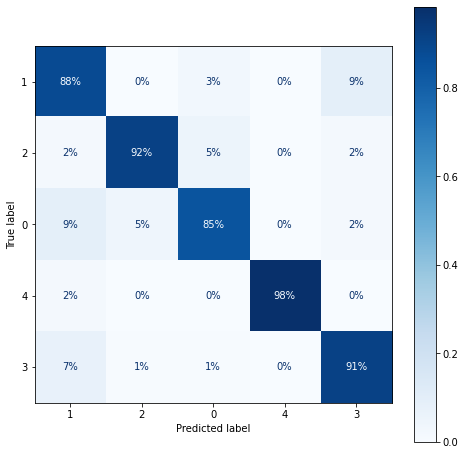

In [ ]:
tree_Entropy = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'entropy', random_state = SEED)
tree_Entropy = tree_Entropy.fit(X_train, y_train)
tree_Entropy_pred = tree_Entropy.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Entropy_pred, y_test)
tree_preci = precision_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Entropy"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(tree_Entropy, X_test, y_test, 
                      display_labels = levels, cmap = plt.cm.Blues,
                      values_format = '0.0%', normalize = 'true',
                      ax = ax
                      )

In [ ]:
# Decision TREE: Gini

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 5} with a score of 0.88


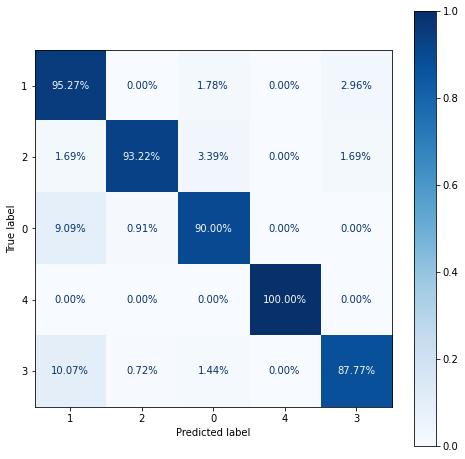

In [ ]:
tree_Gini = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'gini', random_state = SEED)
tree_Gini = tree_Gini.fit(X_train, y_train)
tree_Gini_pred = tree_Gini.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Gini_pred, y_test)
tree_preci = precision_score(tree_Gini_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Gini_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Gini"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(tree_Gini, X_test, y_test, display_labels = levels, cmap = plt.cm.Blues, 
                      values_format = '0.2%',  normalize = 'true',
                      ax = ax
                      )

In [ ]:
# Random forest - Entropy criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'entropy', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 13} with a score of 0.92


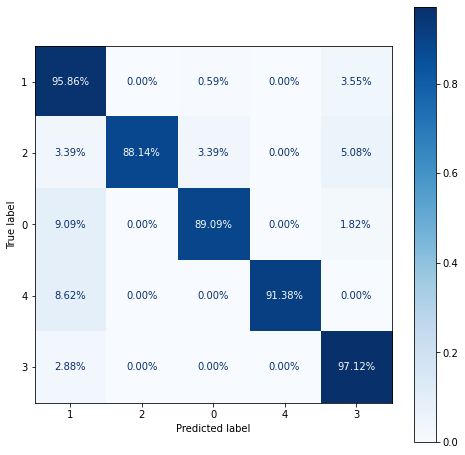

In [ ]:
forest_Entropy = RandomForestClassifier(max_depth = opt_depth, criterion = 'entropy', n_estimators = 200, random_state = SEED)
forest_Entropy = forest_Entropy.fit(X_train, y_train)
forest_Entropy_pred = forest_Entropy.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Entropy_pred, y_test)
forest_preci = precision_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Entropy"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(forest_Entropy, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      ax = ax
                      )

In [ ]:
# Random forest - Gini criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'gini', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 15} with a score of 0.92


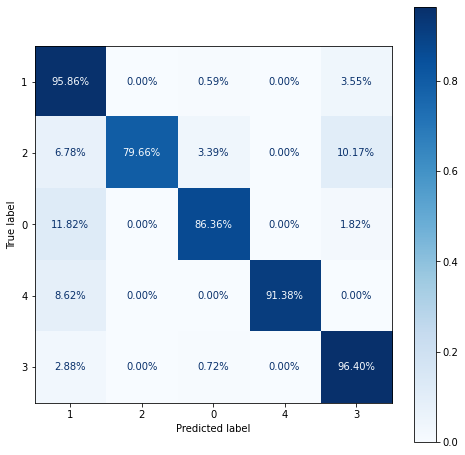

In [ ]:
forest_Gini = RandomForestClassifier(max_depth = opt_depth, criterion = 'gini', n_estimators = 200, random_state = SEED)
forest_Gini = forest_Gini.fit(X_train, y_train)
forest_Gini_pred = forest_Gini.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Gini_pred, y_test)
forest_preci = precision_score(forest_Gini_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Gini_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Gini"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(forest_Gini, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      ax = ax
                      )


In [ ]:
# KNN

# Evaluating best parameters
neigh = np.arange(2, 20)
parameters = {'n_neighbors': neigh}
clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_neigh = clf.best_params_['n_neighbors']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'n_neighbors': 19} with a score of 0.88


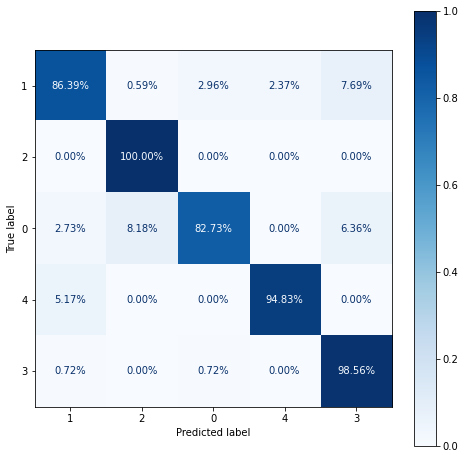

In [ ]:
knn = KNeighborsClassifier(opt_neigh)
knn = knn.fit(X_train, y_train)
neigh_predict = knn.predict(X_test)

#metrics:
neigh_acc = accuracy_score(neigh_predict, y_test)
neigh_preci = precision_score(neigh_predict, y_test, average = 'weighted')
neigh_sensitivity = recall_score(neigh_predict, y_test, average = 'weighted')
neigh_f1 = f1_score(neigh_predict, y_test, average = 'weighted')

classification_metrics.loc["KNN"] = [neigh_acc,neigh_preci,neigh_sensitivity,neigh_f1]
fig, ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(knn, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      ax = ax
                      )

In [ ]:
classification_metrics.sort_values('F1 Score')

,Accuracy,Precision,Sensitivity,F1 Score
Tree Entropy,0.897196,0.897970,0.897196,0.897212
KNN,0.912150,0.919836,0.912150,0.912974
Forest Gini,0.917757,0.923852,0.917757,0.917973
Tree Gini,0.925234,0.927245,0.925234,0.925051
Forest Entropy,0.934579,0.937312,0.934579,0.934415
Logistic regression,0.968224,0.969162,0.968224,0.968146


In [ ]:
#On categories

y = df_eng['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = SEED, stratify = y)

In [ ]:
levels = pd.unique(y)

In [ ]:
classification_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Sensitivity", "F1 Score"])


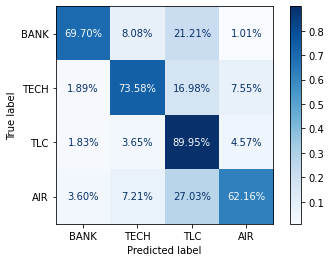

In [ ]:
# LOGISTIC REGRESSION
logistic = LogisticRegression(max_iter = 10000, random_state = SEED, solver = 'lbfgs').fit(X_train, y_train)
logistic_predict = logistic.predict(X_test)

#metrics:
logi_acc = accuracy_score(logistic_predict, y_test)
logi_preci = precision_score(logistic_predict, y_test, average = 'weighted')
logi_sensitivity = recall_score(logistic_predict, y_test, average = 'weighted')
logi_f1 = f1_score(logistic_predict, y_test, average = 'weighted')

classification_metrics.loc["Logistic regression"] = [logi_acc,logi_preci,logi_sensitivity,logi_f1]
plot_confusion_matrix(logistic, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [ ]:
# Decision TREE: Entropy

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'entropy', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 5} with a score of 0.69


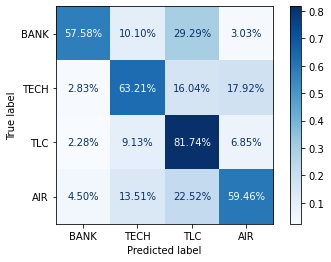

In [ ]:
tree_Entropy = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'entropy', random_state = SEED)
tree_Entropy = tree_Entropy.fit(X_train, y_train)
tree_Entropy_pred = tree_Entropy.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Entropy_pred, y_test)
tree_preci = precision_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Entropy_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Entropy"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
plot_confusion_matrix(tree_Entropy, X_test, y_test, 
                      display_labels = levels, cmap = plt.cm.Blues,
                      values_format = '0.2%', normalize = 'true',
                      )

In [ ]:
# Decision TREE: Gini

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(tree.DecisionTreeClassifier(criterion = 'gini', random_state = SEED), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 6} with a score of 0.68


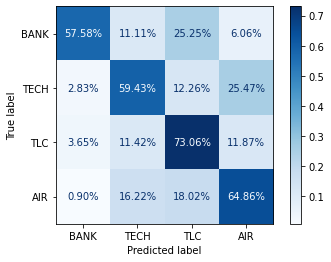

In [ ]:
tree_Gini = tree.DecisionTreeClassifier(max_depth = opt_depth, criterion = 'gini', random_state = SEED)
tree_Gini = tree_Gini.fit(X_train, y_train)
tree_Gini_pred = tree_Gini.predict(X_test)

#metrics
tree_acc = accuracy_score(tree_Gini_pred, y_test)
tree_preci = precision_score(tree_Gini_pred, y_test, average = 'weighted')
tree_sensitivity = recall_score(tree_Gini_pred, y_test, average = 'weighted')
tree_f1 = f1_score(tree_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Tree Gini"] = [tree_acc, tree_preci, tree_sensitivity, tree_f1]
plot_confusion_matrix(tree_Gini, X_test, y_test, display_labels = levels, cmap = plt.cm.Blues, 
                      values_format = '0.2%',  normalize = 'true',
                      )

In [ ]:
# Random forest - Entropy criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'entropy', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 15} with a score of 0.68


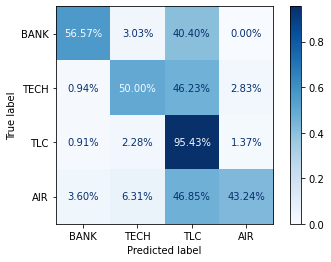

In [ ]:
forest_Entropy = RandomForestClassifier(max_depth = opt_depth, criterion = 'entropy', n_estimators = 200, random_state = SEED)
forest_Entropy = forest_Entropy.fit(X_train, y_train)
forest_Entropy_pred = forest_Entropy.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Entropy_pred, y_test)
forest_preci = precision_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Entropy_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Entropy_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Entropy"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
plot_confusion_matrix(forest_Entropy, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [ ]:
# Random forest - Gini criterion

# Evaluating best parameters
depth = np.arange(4, 20) 
parameters = {'max_depth': depth}
clf = GridSearchCV(RandomForestClassifier(criterion = 'gini', n_estimators = 200, random_state = SEED,
                                          ), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_depth = clf.best_params_['max_depth']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'max_depth': 19} with a score of 0.68


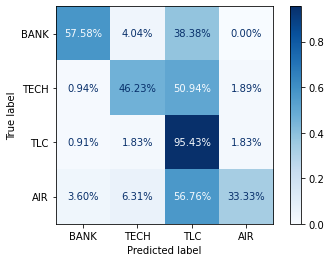

In [ ]:
forest_Gini = RandomForestClassifier(max_depth = opt_depth, criterion = 'gini', n_estimators = 200, random_state = SEED)
forest_Gini = forest_Gini.fit(X_train, y_train)
forest_Gini_pred = forest_Gini.predict(X_test)

#metrics
forest_acc = accuracy_score(forest_Gini_pred, y_test)
forest_preci = precision_score(forest_Gini_pred, y_test, average = 'weighted')
forest_sensitivity = recall_score(forest_Gini_pred, y_test, average = 'weighted')
forest_f1 = f1_score(forest_Gini_pred, y_test, average = 'weighted')

classification_metrics.loc["Forest Gini"] = [forest_acc,forest_preci,forest_sensitivity,forest_f1]
plot_confusion_matrix(forest_Gini, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [ ]:
# KNN

# Evaluating best parameters
neigh = np.arange(2, 20)
parameters = {'n_neighbors': neigh}
clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring = 'f1_weighted')
clf = clf.fit(X_train, y_train)
opt_neigh = clf.best_params_['n_neighbors']
print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))

The best parameters are {'n_neighbors': 16} with a score of 0.72


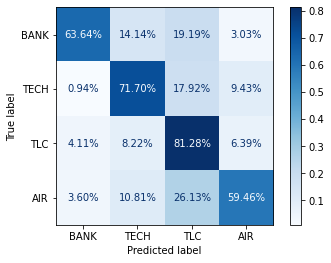

In [ ]:
knn = KNeighborsClassifier(opt_neigh)
knn = knn.fit(X_train, y_train)
neigh_predict = knn.predict(X_test)

#metrics:
neigh_acc = accuracy_score(neigh_predict, y_test)
neigh_preci = precision_score(neigh_predict, y_test, average = 'weighted')
neigh_sensitivity = recall_score(neigh_predict, y_test, average = 'weighted')
neigh_f1 = f1_score(neigh_predict, y_test, average = 'weighted')

classification_metrics.loc["KNN"] = [neigh_acc,neigh_preci,neigh_sensitivity,neigh_f1]
plot_confusion_matrix(knn, X_test, y_test, display_labels = levels,
                      cmap = plt.cm.Blues, 
                      values_format = '0.2%', normalize = 'true',
                      )

In [ ]:
classification_metrics.sort_values('F1 Score')

,Accuracy,Precision,Sensitivity,F1 Score
Tree Gini,0.657944,0.660761,0.657944,0.655165
Forest Gini,0.657944,0.800272,0.657944,0.679062
Tree Entropy,0.689720,0.704068,0.689720,0.692387
Forest Entropy,0.684112,0.798142,0.684112,0.698162
KNN,0.715888,0.727977,0.715888,0.717726
Logistic regression,0.771963,0.792707,0.771963,0.775445
